## Market Evolution & Temporal Dynamics

The geographic analysis revealed downtown's current dominance—professional hosts, premium pricing, and quality competition. But Thessaloniki's short-term rental market is young and rapidly expanding. This notebook traces **temporal patterns** to understand how the market is evolving and what trajectory it's on.

### Research Questions
1. How has the STR market expanded over time? Which years saw the biggest influx of new listings?
2. Are new listings concentrating in existing hotspots or expanding to peripheral areas?
3. Which host categories are driving recent growth? Are large operators accelerating their expansion?
4. What price segments are new entrants targeting—premium or budget?
5. Do newer listings maintain the quality standards of established ones, or is rapid growth diluting market quality?

### Analytical Framework: Market Maturity

To analyze temporal patterns, listings are categorized by their **time in market** based on first review date:

| Category | Time Since First Review | Market Profile |
|----------|------------------------|----------------|
| **New** | < 2 years | Recent entrants, still establishing reputation |
| **Growing** | 2-4 years | Maturing listings, building review history |
| **Mature** | 4-8 years | Established presence, stable performance |
| **Established** | > 8 years | Market veterans, pre-dating STR boom |

<br>

> **Note**: First review date serves as a proxy for market entry. Listings without reviews are excluded from temporal analysis as their entry timing cannot be determined.

### Key Finding Preview
> *Thessaloniki's STR market is undergoing a **quality divergence** driven by rapid post-pandemic expansion. While the premium segment self-regulates effectively, the budget segment—particularly among new Large multihost operators—shows signs of emerging quality concerns that warrant attention.*

<hr>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

sys.path.insert(0, str(Path.cwd().parent))
from scripts.eda_functions import (
    analyze_numeric_variable,
    analyze_categorical_variable,
    analyze_categorical_numerical,
    analyze_categorical_categorical
    )

In [2]:
data_path = Path.cwd().parent / "data" / "processed"
df = pd.read_parquet(data_path / "listings_regular_license.parquet", engine="pyarrow")
pd.set_option('display.float_format', '{:,.2f}'.format)
print(f"Dataset shape: {df.shape}")

Dataset shape: (4124, 54)


In [3]:
# Set global style and color palette
sns.set_theme(style="whitegrid")
sns.set_palette("Paired")  # or "husl", "muted", "pastel", "deep", "colorblind"

# For matplotlib defaults
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("Paired"))

In [4]:
ZONE_ORDER = ['Downtown (<1km)', 'Inner City (1-3km)', 'Neighborhoods (3-6km)', 'Suburban (>6km)']
REVERSE_ZONE_ORDER = ZONE_ORDER[::-1]  # For plotting from Downtown to Suburban
HOST_ORDER = ['Individual (1)', 'Small Multi (2-3)', 'Medium Multi (4-10)', 'Large Multi (11+)']
REVERSE_HOST_ORDER = HOST_ORDER[::-1]
PRICE_ORDER = ['Very Low (<40€)', 'Low (40-60€)', 'Medium (60-80€)', 'High (80-120€)', 'Very High (>120€)']
MATURITY_ORDER = ['New (<2yr)' , 'Growing (2-4yr)', 'Mature (4-8yr)', 'Established (>8yr)']

# Color mapping for host categories
host_colors = {
    'Individual (1)': '#D7BD92',
    'Small Multi (2-3)': '#81B29A',
    'Medium Multi (4-10)': '#127C7F',
    'Large Multi (11+)': '#3D405B'
}

# Color mapping for distance categories (warm to cool progression)
zone_colors = {
    'Downtown (<1km)': '#C39990',
    'Inner City (1-3km)': '#9A8C98',
    'Neighborhoods (3-6km)': '#5F6487',
    'Suburban (>6km)': '#22223B'
}

# Color mapping for price categories (light to dark progression)
price_colors = {
    'Very Low (<40€)': '#ABAFC5',
    'Low (40-60€)': '#8188A7',
    'Medium (60-80€)': '#57608A',
    'High (80-120€)': '#222A52',
    'Very High (>120€)': '#171C37'
}

<hr>

## A Young Market

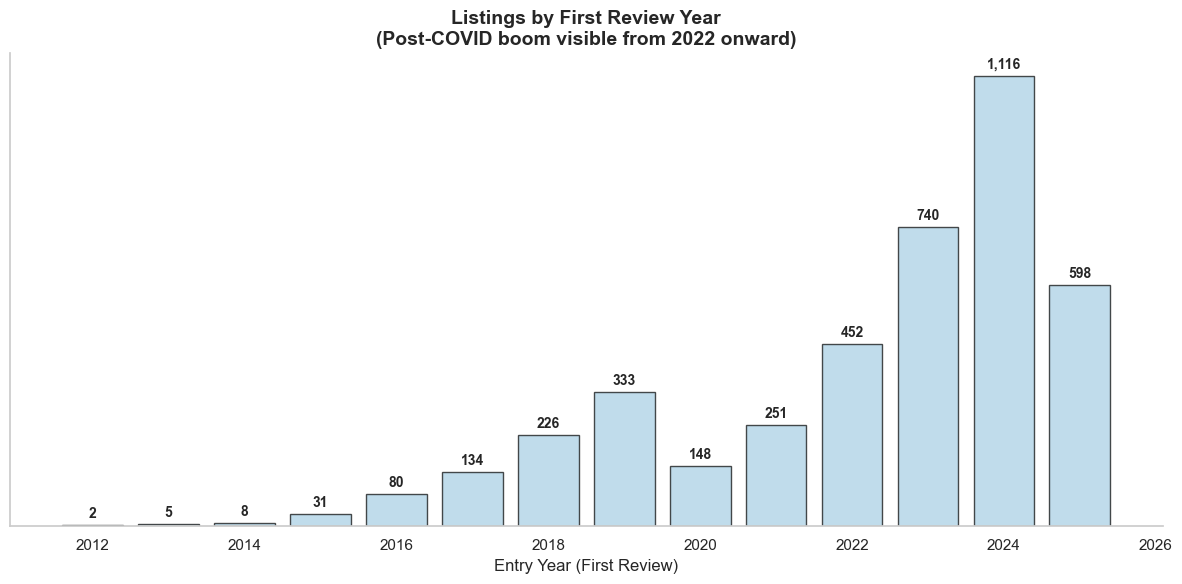

In [5]:
# Bar Chart: Number of New Listings by Entry Year
fig, ax = plt.subplots(figsize=(12, 6))

# Extract year from first_review_date and count
yearly_counts = df['first_review_date'].dt.year.value_counts().sort_index()

# Create bar chart
bars = ax.bar(yearly_counts.index, yearly_counts.values, edgecolor='black', alpha=0.7)

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 10,
            f'{int(height):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Styling
ax.set_xlabel('Entry Year (First Review)', fontsize=12)
ax.set_title('Listings by First Review Year\n(Post-COVID boom visible from 2022 onward)', 
             fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3)
ax.grid(axis='x', alpha=0.0)
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

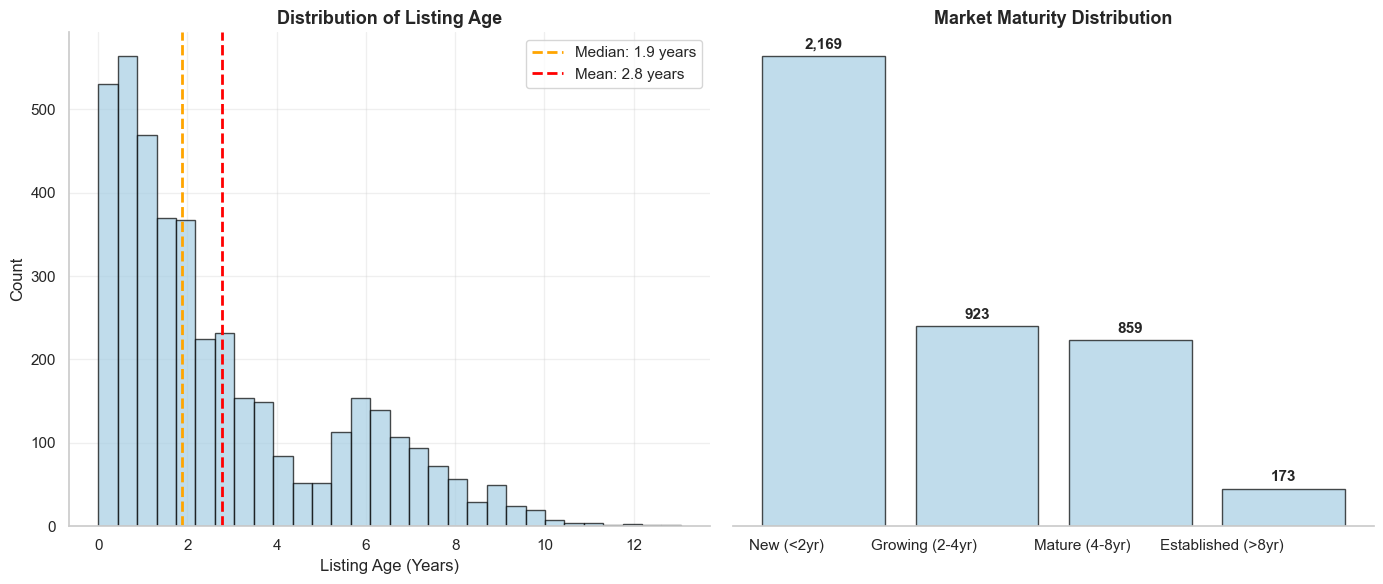

In [6]:
# Listing Age Distribution: Histogram and Market Maturity Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Histogram of listing_age_years
axes[0].hist(df['listing_age_years'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Listing Age (Years)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Listing Age', 
              fontsize=13, fontweight='bold')
axes[0].axvline(df['listing_age_years'].median(), color='orange', linestyle='--', 
            linewidth=2, label=f'Median: {df["listing_age_years"].median():.1f} years')
axes[0].axvline(df['listing_age_years'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {df["listing_age_years"].mean():.1f} years')
axes[0].legend()
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].grid(True, alpha=0.3)

# Right: Bar plot of market_maturity
maturity_counts = df['market_maturity'].value_counts()
maturity_counts = maturity_counts.reindex(MATURITY_ORDER)

bars = axes[1].bar(range(len(MATURITY_ORDER)), maturity_counts.values, 
               edgecolor='black', alpha=0.7)

# Add count labels on top of bars
for i, (bar, count) in enumerate(zip(bars, maturity_counts.values)):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             f'{count:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[1].set_xticks(range(len(MATURITY_ORDER)))
axes[1].set_xticklabels(MATURITY_ORDER, rotation=0, ha='right')
axes[1].set_ylabel('')
axes[1].set_title('Market Maturity Distribution', 
              fontsize=13, fontweight='bold')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].set_yticks([])
axes[1].grid(False)

plt.tight_layout()
plt.show()

In [7]:
print("Listing Age Summary:")
print(df.listing_age_years.describe())

Listing Age Summary:
count   4,124.00
mean        2.78
std         2.51
min         0.00
25%         0.82
50%         1.89
75%         4.00
max        13.06
Name: listing_age_years, dtype: float64


In [8]:
# Market maturity distribution
maturity_counts = df["market_maturity"].value_counts()
maturity_proportions = df["market_maturity"].value_counts(normalize=True).reindex(MATURITY_ORDER)

print("="*60)
print("MARKET MATURITY DISTRIBUTION")
print("="*60)
print(f"\nTotal listings: {len(df):,}")
print("\nDistribution by cohort:")
for maturity in MATURITY_ORDER:
    count = maturity_counts[maturity]
    proportion = maturity_proportions[maturity]
    print(f"  {maturity:30s}: {proportion*100:5.1f}% ({count:,} listings)")

MARKET MATURITY DISTRIBUTION

Total listings: 4,124

Distribution by cohort:
  New (<2yr)                    :  52.6% (2,169 listings)
  Growing (2-4yr)               :  22.4% (923 listings)
  Mature (4-8yr)                :  20.8% (859 listings)
  Established (>8yr)            :   4.2% (173 listings)


#### **Main Findings**

* Thessaloniki's STR market is a young, rapidly evolving market: Over half of all active listings are less than 2 years old.
* There is a post-pandemic explosion of new listings. Particularly from 2022 onwards, every new year has been a record-breaker for new market entrants.
* There was a slow but steady growth in the market just before the pandemic, with listings gradually increasing from 2015 to 2019.
* Listings from 2025 are set to match or even exceed those from 2024, indicating continued strong growth (the data stops at June 2025).

<hr>

## Where Is Growth Happening?

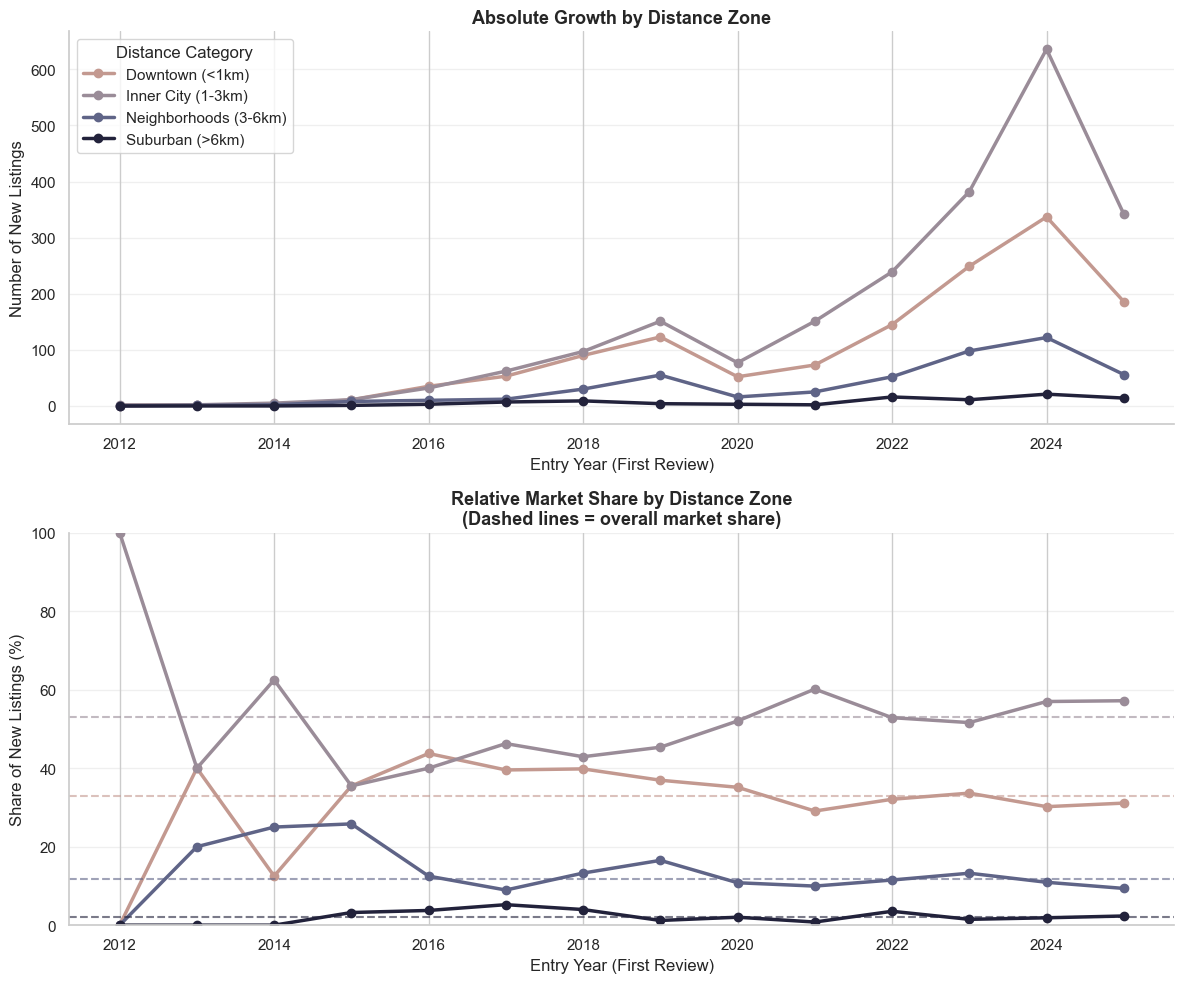

In [9]:
# Grid Layout: Absolute Growth + Relative Share
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Top: Absolute counts (your original plot)
yearly_zone = df.groupby([df['first_review_date'].dt.year, 'distance_cat'], observed=True).size().unstack(fill_value=0)
yearly_zone = yearly_zone[ZONE_ORDER]

for zone in ZONE_ORDER:
    axes[0].plot(yearly_zone.index, yearly_zone[zone], 
                 marker='o', linewidth=2.5, label=zone, 
                 color=zone_colors[zone])

axes[0].set_xlabel('Entry Year (First Review)', fontsize=12)
axes[0].set_ylabel('Number of New Listings', fontsize=12)
axes[0].set_title('Absolute Growth by Distance Zone', 
                   fontsize=13, fontweight='bold')
axes[0].legend(title='Distance Category', loc='upper left')
axes[0].grid(axis='y', alpha=0.3)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Bottom: Percentage share
yearly_zone_pct = yearly_zone.div(yearly_zone.sum(axis=1), axis=0) * 100

for zone in ZONE_ORDER:
    axes[1].plot(yearly_zone_pct.index, yearly_zone_pct[zone], 
                 marker='o', linewidth=2.5, label=zone, 
                 color=zone_colors[zone])

# Calculate overall market share for each distance category
overall_market_share = df['distance_cat'].value_counts(normalize=True).reindex(ZONE_ORDER) * 100

# Add horizontal lines for overall market share
for zone in ZONE_ORDER:
    share = overall_market_share[zone]
    axes[1].axhline(y=share, color=zone_colors[zone], linestyle='--', 
                    linewidth=1.5, alpha=0.6, 
                    label=f'{zone} overall: {share:.1f}%')

axes[1].set_xlabel('Entry Year (First Review)', fontsize=12)
axes[1].set_ylabel('Share of New Listings (%)', fontsize=12)
axes[1].set_title('Relative Market Share by Distance Zone\n(Dashed lines = overall market share)', 
                   fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

#### **Main Findings**

* Inner City and Downtown listings continue to lead the market growth pattern.
* Expansion for peripheral areas remains marginal despite the post-pandemic boom.
* Since 2020, each distance zone's share has converged toward its overall market share — geographic distribution has stabilized.
* Early volatility in market share is not meaningful due to small sample sizes.

<hr>

## Who's Driving the Boom?

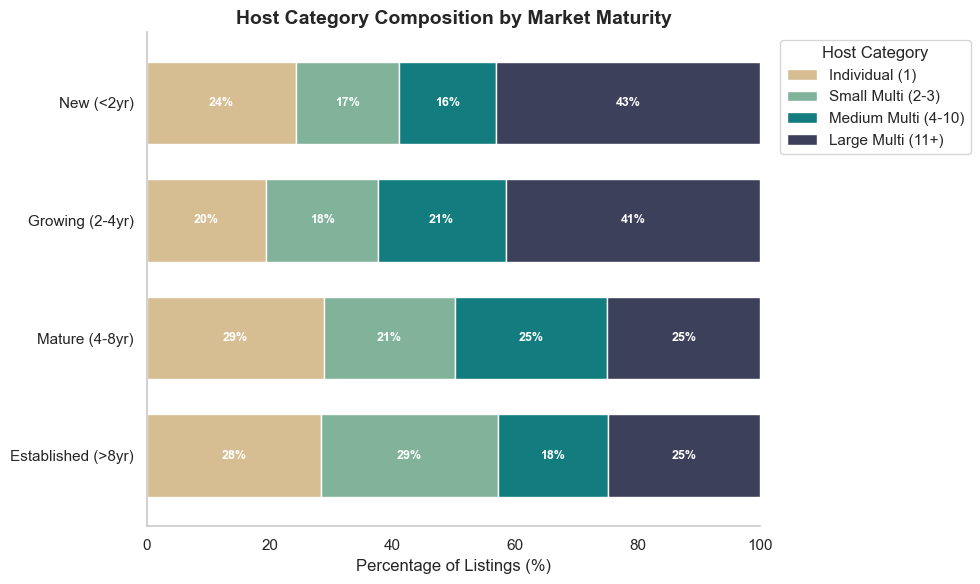

In [10]:
# 100% Stacked Bar Chart: Host Category Distribution by Market Maturity
fig, ax = plt.subplots(figsize=(10, 6))

# Create crosstab with percentages
ct = pd.crosstab(df['market_maturity'], df['host_category'], normalize='index') * 100

# Use existing maturity order (old to new)
ct = ct.reindex(MATURITY_ORDER[::-1])  # Reverse to show Established -> New

# Use existing host order (small to large for stacking)
ct = ct[HOST_ORDER]

# Plot stacked bar with existing color scheme
ct.plot(kind='barh', stacked=True, ax=ax, width=0.7, color=[host_colors[h] for h in HOST_ORDER])

# Add percentage labels to each segment
for i, maturity in enumerate(MATURITY_ORDER[::-1]):
    cumsum = 0
    for host_cat in HOST_ORDER:
        width = ct.loc[maturity, host_cat]
        if width > 8:  # Only label segments > 8%
            ax.text(cumsum + width/2, i, f'{width:.0f}%', 
                    ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        cumsum += width

# Styling
ax.set_xlabel('Percentage of Listings (%)', fontsize=12)
ax.set_ylabel('')
ax.set_title('Host Category Composition by Market Maturity', 
             fontsize=14, fontweight='bold')
ax.legend(title='Host Category', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xlim(0, 100)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(False)
plt.tight_layout()
plt.show()


In [11]:
# Chi-square test: host_category vs market_maturity
contingency_table = pd.crosstab(df['market_maturity'], df['host_category'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Cramér's V effect size
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

# Print results
print("=" * 60)
print("Chi-Square Test: Host Category vs Market Maturity")
print("=" * 60)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.10f}")
print(f"Degrees of freedom: {dof}")
print(f"Cramér's V: {cramers_v:.3f}")

# Effect size interpretation
if cramers_v < 0.1:
    effect = "negligible"
elif cramers_v < 0.3:
    effect = "small"
elif cramers_v < 0.5:
    effect = "moderate"
else:
    effect = "large"
print(f"Effect size: {effect}")

Chi-Square Test: Host Category vs Market Maturity
Chi-square statistic: 126.46
p-value: 0.0000000000
Degrees of freedom: 9
Cramér's V: 0.101
Effect size: small


#### **Main Findings**

* Large Multi hosts capture 43% of new market entries, nearly doubling their share among pre-2021 listings (25%). 
* Individual hosts rebound in the market (24% from 20%) after losing a significant market share in previous years, suggesting a renewed interest in casual hosting
* Small and medium multihosts see their share squeezed out as the market evolves (46% Established -> 39% Mature -> 33% New).

#### **Comment:** 

The post-pandemic boom reveals market polarization driven by tourism optimism. Two forces are simultaneously reshaping Thessaloniki's STR landscape:

* Large multihosts almost doubled their market share, a sign that institutional capital enters the sector.
* Individual hosts rebounded from their COVID-era decline, as Greeks increasingly view tourism as an accessible income stream.

As mid-scale operators are losing ground,the market seems to bifurcate into professional platforms vs. personal hosting, with little room for hybrid models.

<hr>

## Price Segment Targeting

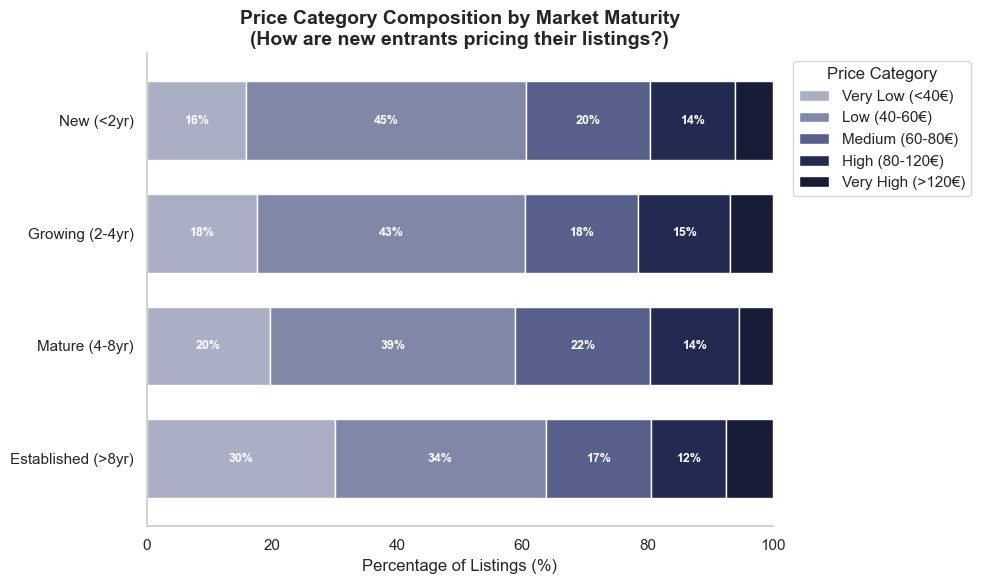

In [12]:
# 100% Stacked Bar Chart: Price Category Distribution by Market Maturity
fig, ax = plt.subplots(figsize=(10, 6))

# Create crosstab with percentages
ct = pd.crosstab(df['market_maturity'], df['price_cat'], normalize='index') * 100

# Use existing maturity order (old to new)
ct = ct.reindex(MATURITY_ORDER[::-1])  # Reverse to show Established -> New

# Use existing price order (low to high for stacking)
ct = ct[PRICE_ORDER]

# Plot stacked bar with existing color scheme
ct.plot(kind='barh', stacked=True, ax=ax, width=0.7, color=[price_colors[p] for p in PRICE_ORDER])

# Add percentage labels to each segment
for i, maturity in enumerate(MATURITY_ORDER[::-1]):
    cumsum = 0
    for price_cat in PRICE_ORDER:
        width = ct.loc[maturity, price_cat]
        if width > 8:  # Only label segments > 8%
            ax.text(cumsum + width/2, i, f'{width:.0f}%', 
                    ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        cumsum += width

# Styling
ax.set_xlabel('Percentage of Listings (%)', fontsize=12)
ax.set_ylabel('')
ax.set_title('Price Category Composition by Market Maturity\n(How are new entrants pricing their listings?)', 
             fontsize=14, fontweight='bold')
ax.legend(title='Price Category', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xlim(0, 100)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(False)
plt.tight_layout()
plt.show()

In [13]:
# Chi-square test: price_cat vs market_maturity
contingency_table = pd.crosstab(df['market_maturity'], df['price_cat'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Cramér's V effect size
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print("=" * 60)
print("Chi-Square Test: Price Category vs Market Maturity")
print("=" * 60)
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.10f}")
print(f"Degrees of freedom: {dof}")
print(f"Cramér's V: {cramers_v:.3f}")

# Effect size interpretation
if cramers_v < 0.1:
    effect = "negligible"
elif cramers_v < 0.2:
    effect = "small"
elif cramers_v < 0.4:
    effect = "moderate"
else:
    effect = "large"
print(f"Effect size: {effect}")

Chi-Square Test: Price Category vs Market Maturity
Chi-square statistic: 33.21
p-value: 0.0008972341
Degrees of freedom: 12
Cramér's V: 0.053
Effect size: negligible


#### **Main Findings**

* Price segment distribution has remained largely stable across market cohorts.
* The Low (€40-60) segment shows modest gains at the expense of Very Low (<€40), suggesting slight upward price positioning among newer entrants.

<hr>

## The Quality Divergence

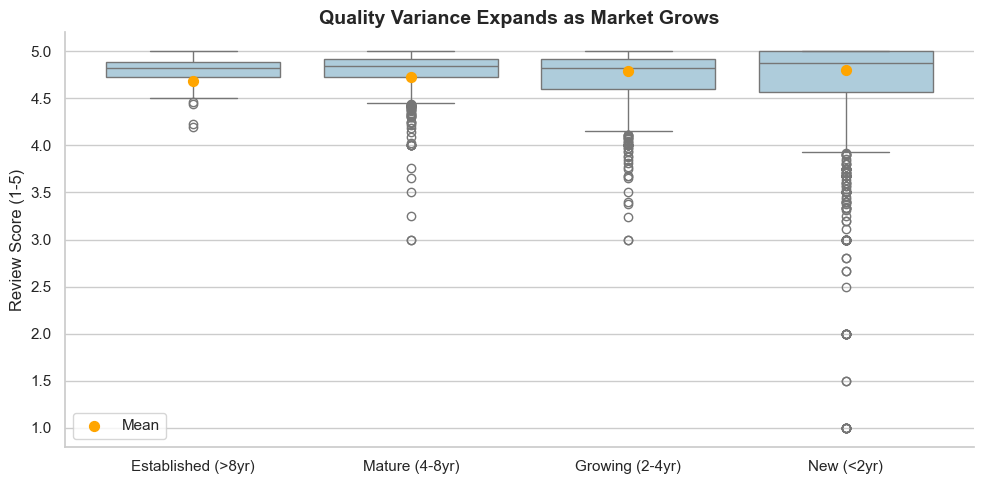

In [14]:
# Box Plot: Review Scores by Market Maturity
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=df, x='market_maturity', y='review_scores_rating', 
            order=MATURITY_ORDER[::-1], ax=ax)

# Add mean markers
means = df.groupby('market_maturity', observed=True)['review_scores_rating'].mean().reindex(MATURITY_ORDER)
ax.scatter(range(len(MATURITY_ORDER)), means, color='orange', s=50, zorder=5, label='Mean')
ax.set_xlabel('')
ax.set_ylabel('Review Score (1-5)', fontsize=12)
ax.set_title('Quality Variance Expands as Market Grows', 
             fontsize=14, fontweight='bold')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [15]:
# Extract ratings by maturity group
established = df[df['market_maturity'] == 'Established (>8yr)']['review_scores_rating'].dropna()
mature = df[df['market_maturity'] == 'Mature (4-8yr)']['review_scores_rating'].dropna()
growing = df[df['market_maturity'] == 'Growing (2-4yr)']['review_scores_rating'].dropna()
new = df[df['market_maturity'] == 'New (<2yr)']['review_scores_rating'].dropna()

# Levene's test for equal variances
stat, p_value = stats.levene(established, mature, growing, new, center='median')

print("Levene's Test for Variance Homogeneity")
print("=" * 60)
print(f"Test statistic: {stat:.2f}")
print(f"P-value: {p_value:.6f}")
if p_value < 0.001:
    print("Result: Significant evidence of unequal variances (p < 0.001)")
else:
    print(f"Result: {'Significant' if p_value < 0.05 else 'No significant'} variance differences")

# Calculate variance and coefficient of variation for each group
print("\n" + "=" * 60)
print("Variance Analysis by Market Maturity")
print("=" * 60)

groups = {
    'Established (>8yr)': established,
    'Mature (4-8yr)': mature,
    'Growing (2-4yr)': growing,
    'New (<2yr)': new
}

results = []
for name, data in groups.items():
    variance = data.var()
    std = data.std()
    mean = data.mean()
    median = data.median()
    results.append({
        'Group': name,
        'Variance (σ²)': variance,
        'Std Dev (σ)': std,
        'Mean (μ)': mean,
        'Median' : median,
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Calculate variance ratios (effect sizes)
print("\n" + "=" * 60)
print("Effect Sizes: Standard Deviation Ratios")
print("=" * 60)

baseline_std = mature.std()
for name, data in groups.items():
    if name != 'Mature (4-8yr)':
        std_ratio = data.std() / baseline_std
        print(f"{name:25s} std is {std_ratio:.2f}x Mature")

Levene's Test for Variance Homogeneity
Test statistic: 54.21
P-value: 0.000000
Result: Significant evidence of unequal variances (p < 0.001)

Variance Analysis by Market Maturity
             Group  Variance (σ²)  Std Dev (σ)  Mean (μ)  Median
Established (>8yr)           0.02         0.14      4.80    4.82
    Mature (4-8yr)           0.05         0.21      4.79    4.84
   Growing (2-4yr)           0.08         0.28      4.73    4.82
        New (<2yr)           0.26         0.51      4.68    4.87

Effect Sizes: Standard Deviation Ratios
Established (>8yr)        std is 0.64x Mature
Growing (2-4yr)           std is 1.32x Mature
New (<2yr)                std is 2.39x Mature


#### **Main Findings**

* **Variance increases significantly with market age**: New entrants show 2.4x bigger standard deviation than mature listings (σ = 0.21 vs 0.51), a sign that quality predictability declines.
* Despite the increase in variability, median rating is slightly higher in newer listings, a pattern that points to diverging quality trajectories between hosts - some excel immediately while others underperform.

### Quality trajectory between host groups and price segments

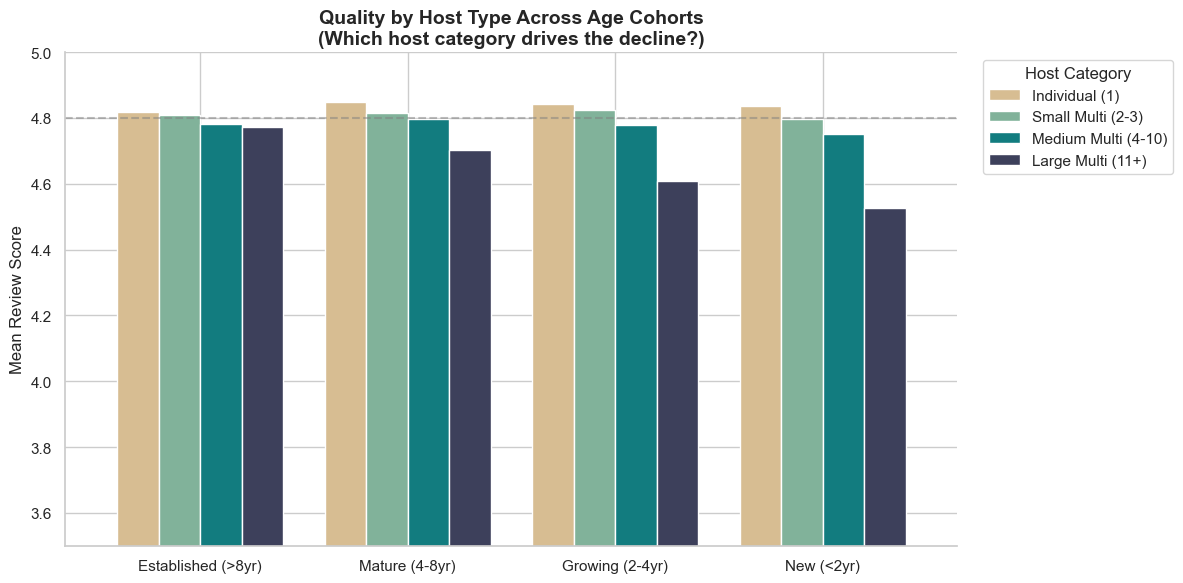

In [16]:
# Mean Rating by Host Category and Market Maturity
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate mean ratings
pivot = df.groupby(['market_maturity', 'host_category'], observed=True)['review_scores_rating'].mean().unstack()
pivot = pivot.reindex(MATURITY_ORDER[::-1])[HOST_ORDER]
ratings_mean = round(df['review_scores_rating'].mean(), 2)

# Plot grouped bars
pivot.plot(kind='bar', ax=ax, width=0.8, color=[host_colors[h] for h in HOST_ORDER])

ax.set_xlabel('')
ax.set_ylabel('Mean Review Score', fontsize=12)
ax.set_title('Quality by Host Type Across Age Cohorts\n(Which host category drives the decline?)', 
             fontsize=14, fontweight='bold')
ax.set_xticklabels(MATURITY_ORDER[::-1], rotation=0)
ax.legend(title='Host Category', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_ylim(3.5, 5.0)
ax.axhline(y=4.8, color='gray', linestyle='--', alpha=0.5, linewidth=1.5, label='Market Average')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

#### **Main Findings**

* While all host categories maintain relatively stable mean ratings over time, more recent listings from large multihosts show a clear downward trend.

Let's zoom in to large multihost ratings over time by price segment to understand this pattern better.

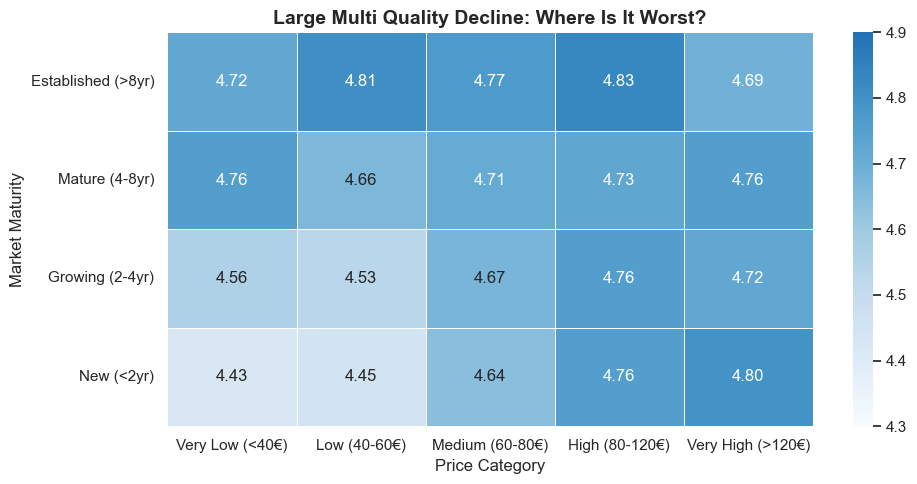

In [17]:
# Heatmap: Large Multi Mean Ratings
fig, ax = plt.subplots(figsize=(10, 5))

large_multi = df[df['host_category'] == 'Large Multi (11+)']

# Create pivot
heatmap_data = large_multi.pivot_table(
    values='review_scores_rating', 
    index='market_maturity', 
    columns='price_cat', 
    aggfunc='mean',
    observed=True
).reindex(MATURITY_ORDER[::-1])[PRICE_ORDER]

# Plot heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='Blues', 
            center=4.7, vmin=4.3, vmax=4.9,
            linewidths=0.5, ax=ax)

ax.set_title('Large Multi Quality Decline: Where Is It Worst?', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Price Category', fontsize=12)
ax.set_ylabel('Market Maturity', fontsize=12)

plt.tight_layout()
plt.show()

In [18]:
# Large Multi Budget Quality Decline
budget_cats = ['Very Low (<40€)', 'Low (40-60€)']
large_multi_budget = df[(df['host_category'] == 'Large Multi (11+)') & 
                        (df['price_cat'].isin(budget_cats))]

# Compare New vs Mature+Established
new_ratings = large_multi_budget[large_multi_budget['market_maturity'].isin(['Growing (2-4yr)','New (<2yr)'])]['review_scores_rating'].dropna()
established_ratings = large_multi_budget[large_multi_budget['market_maturity'].isin([ 'Mature (4-8yr)', 'Established (>8yr)'])]['review_scores_rating'].dropna()

# Mann-Whitney U (non-normal distributions)
stat, p_value = stats.mannwhitneyu(established_ratings, new_ratings, alternative='greater')

# Effect size (rank-biserial correlation)
n1, n2 = len(established_ratings), len(new_ratings)
rank_biserial = 1 - (2 * stat) / (n1 * n2)

print("=" * 60)
print("Large Multi Budget Segment Quality Decline Post 2021")
print("=" * 60)
print(f"Established+Mature mean: {established_ratings.mean():.3f}")
print(f"New entrants mean: {new_ratings.mean():.3f}")
print(f"Difference: {established_ratings.mean() - new_ratings.mean():.3f}")
print(f"\nMann-Whitney U: {stat:.0f}")
print(f"P-value (one-tailed): {p_value:.6f}")
print(f"Rank-biserial r: {rank_biserial:.3f}")

# Effect size interpretation
if abs(rank_biserial) < 0.1:
    effect = "negligible"
elif abs(rank_biserial) < 0.3:
    effect = "small"
elif abs(rank_biserial) < 0.5:
    effect = "medium"
else:
    effect = "large"
print(f"Effect size: {effect}")

Large Multi Budget Segment Quality Decline Post 2021
Established+Mature mean: 4.705
New entrants mean: 4.472
Difference: 0.234

Mann-Whitney U: 79701
P-value (one-tailed): 0.000000
Rank-biserial r: -0.267
Effect size: small


#### **Main Findings**

* The decline in ratings among new large multihost listings is driven by budget (Low and Very Low) priced listings.

### Host types and Price segments

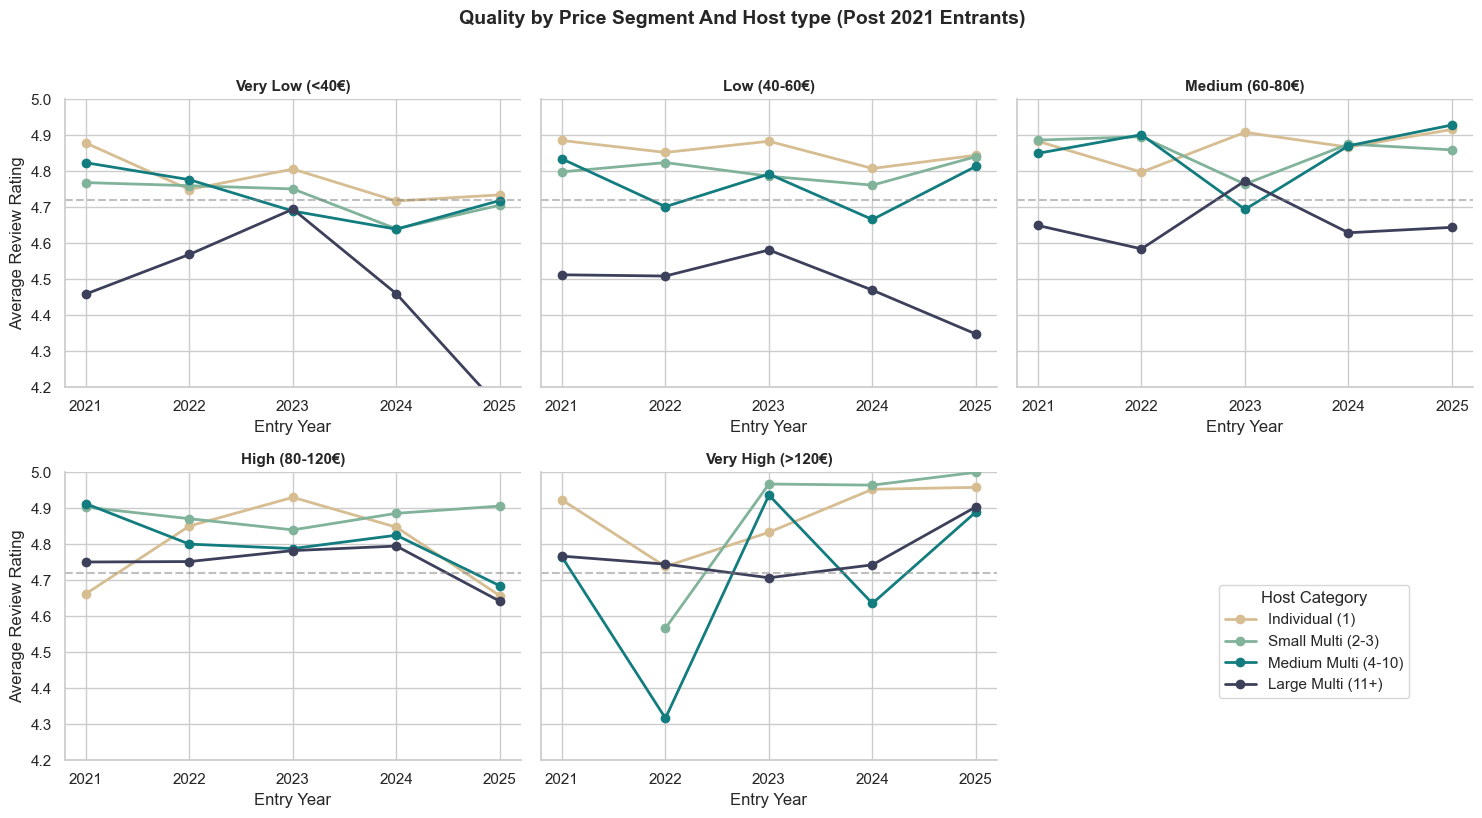

In [19]:
# Filter to post-COVID and create year variable
df_post_covid = df[df['first_review_date'].dt.year >= 2021].copy()

# Alternative view: Facet by Price, lines = Host Category
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

host_colors = [host_colors[h] for h in HOST_ORDER]

for idx, price_cat in enumerate(PRICE_ORDER):
    ax = axes[idx]
    subset = df_post_covid[df_post_covid['price_cat'] == price_cat]
    
    for i, host_cat in enumerate(HOST_ORDER):
        host_subset = subset[subset['host_category'] == host_cat]
        yearly_mean = host_subset.groupby(host_subset['first_review_date'].dt.year)['review_scores_rating'].mean()
        
        if len(yearly_mean) > 1:
            ax.plot(yearly_mean.index, yearly_mean.values, 
                    marker='o', label=host_cat, color=host_colors[i], linewidth=2)
    
    ax.set_title(f'{price_cat}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Entry Year')
    ax.set_ylabel('Average Review Rating' if idx % 3 == 0 else '')
    ax.set_ylim(4.2, 5.0)
    ax.axhline(y=ratings_mean, color='gray', linestyle='--', alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([2021, 2022, 2023, 2024, 2025])

# Hide empty subplot
axes[5].set_visible(False)

# Single legend for all
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Host Category', loc='lower right', bbox_to_anchor=(0.95, 0.15))

fig.suptitle('Quality by Price Segment And Host type (Post 2021 Entrants)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [20]:
# Very High Segment Improvement During The Past 2 Years
very_high = df[df['price_cat'] == 'Very High (>120€)']

# Compare by maturity
new_vh = very_high[very_high['market_maturity'] == 'New (<2yr)']['review_scores_rating'].dropna()
mature_vh = very_high[very_high['market_maturity'].isin(['Growing (2-4yr)', 'Mature (4-8yr)', 'Established (>8yr)'])]['review_scores_rating'].dropna()

stat, p_value = stats.mannwhitneyu(new_vh, mature_vh, alternative='greater')

n1, n2 = len(new_vh), len(mature_vh)
rank_biserial = 1 - (2 * stat) / (n1 * n2)

print("=" * 60)
print("Very High Segment Quality Improvement")
print("=" * 60)
print(f"New entrants mean: {new_vh.mean():.3f}")
print(f"Mature+Established mean: {mature_vh.mean():.3f}")
print(f"Difference: {new_vh.mean() - mature_vh.mean():.3f}")
print(f"\nMann-Whitney U: {stat:.0f}")
print(f"P-value (one-tailed, new > mature): {p_value:.6f}")
print(f"Rank-biserial r: {rank_biserial:.3f}")

# Effect size interpretation
if abs(rank_biserial) < 0.1:
    effect = "negligible"
elif abs(rank_biserial) < 0.3:
    effect = "small"
elif abs(rank_biserial) < 0.5:
    effect = "medium"
else:
    effect = "large"
print(f"Effect size: {effect}")

Very High Segment Quality Improvement
New entrants mean: 4.846
Mature+Established mean: 4.759
Difference: 0.087

Mann-Whitney U: 9558
P-value (one-tailed, new > mature): 0.000001
Rank-biserial r: -0.352
Effect size: medium


#### **Main Findings**

* Large multihosts show steep quality decline during the past two years for both budget categories (Low and Very Low).
* At the same time, Individual and small multihosts maintain stable quality levels across all budget categories.
* All host types converge to a 4.9 - 5 for Very High priced listings, a sign that a serious competition for premium guests is emerging across the board. (medium effect size).

#### **Comment:** 

Zooming in to post-pandemic years the quality decline trend for large multihosts gets clearer. During the first years there was actually a slight increase in ratings but from 2023 onwards the decline becomes evident for both budget categories. it would be interesting to see which areas were most affected by this trend.

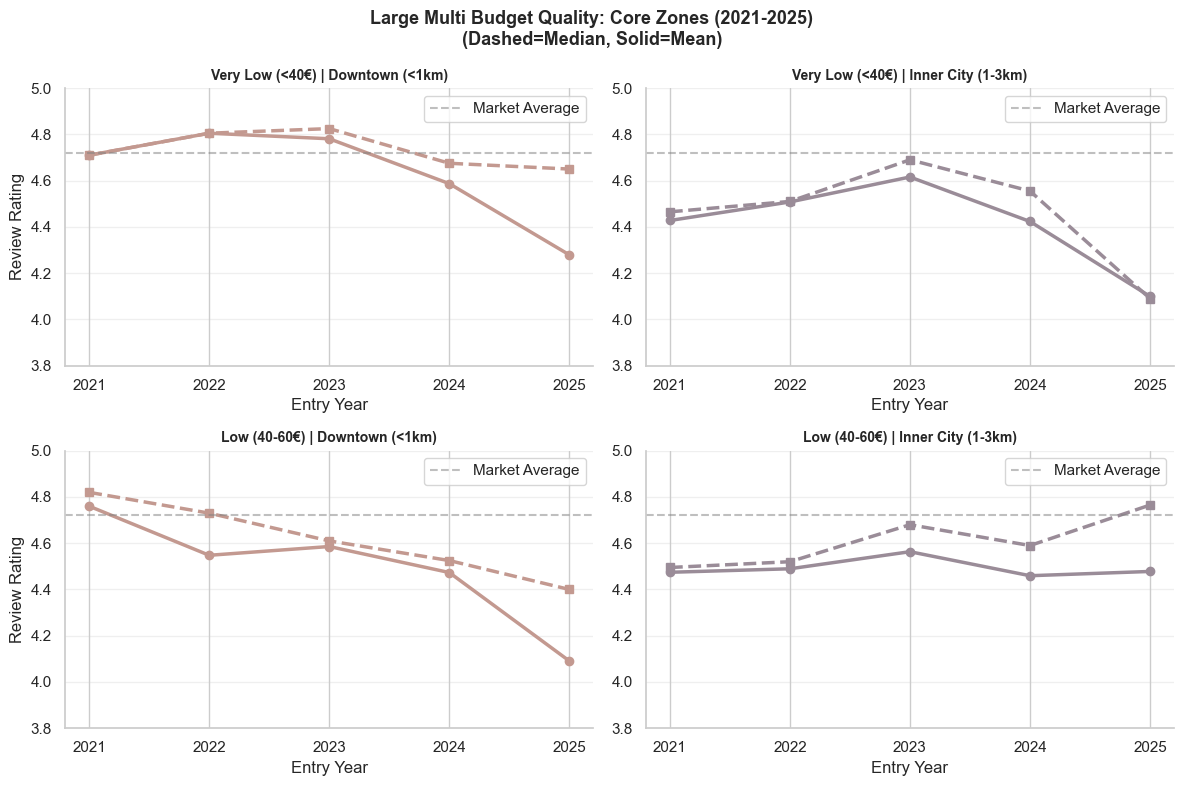

In [21]:
# 2x2 Grid: Large Multi Budget Quality by Core Distance Zones
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Define price categories and zones for the grid
price_zones = [
    ('Very Low (<40€)', 'Downtown (<1km)'),
    ('Very Low (<40€)', 'Inner City (1-3km)'),
    ('Low (40-60€)', 'Downtown (<1km)'),
    ('Low (40-60€)', 'Inner City (1-3km)')
]

for idx, (price_cat, zone) in enumerate(price_zones):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Filter data
    subset = df_post_covid[(df_post_covid['host_category'] == 'Large Multi (11+)') & 
                            (df_post_covid['price_cat'] == price_cat) &
                            (df_post_covid['distance_cat'] == zone)]
    
    # Calculate yearly mean
    yearly_mean = subset.groupby(subset['first_review_date'].dt.year)['review_scores_rating'].mean()
    yearly_median = subset.groupby(subset['first_review_date'].dt.year)['review_scores_rating'].median()
    
    if len(yearly_mean) > 0:
        ax.plot(yearly_mean.index, yearly_mean.values, 
                marker='o', linewidth=2.5, color=zone_colors[zone])
        
    if len(yearly_median) > 0:
        ax.plot(yearly_median.index, yearly_median.values, 
                marker='s', linestyle='--', linewidth=2.5, color=zone_colors[zone])
    
    ax.set_title(f'{price_cat} | {zone}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Entry Year')
    ax.set_ylabel('Review Rating' if col == 0 else '')
    ax.set_ylim(3.8, 5.0)
    ax.axhline(y=ratings_mean, color='gray', linestyle='--', alpha=0.5, linewidth=1.5, label='Market Average')
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([2021, 2022, 2023, 2024, 2025])
    ax.set_xticklabels([2021, 2022, 2023, 2024, 2025], rotation=0)
    ax.grid(axis='y', alpha=0.3)

fig.suptitle('Large Multi Budget Quality: Core Zones (2021-2025)\n(Dashed=Median, Solid=Mean)', 
             fontsize=13, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [22]:
# Large Multi Budget Quality Decline
budget_cats = ['Very Low (<40€)', 'Low (40-60€)']
large_multi_budget = df[(df['host_category'] == 'Large Multi (11+)') & 
                        (df['price_cat'].isin(budget_cats))]

# Compare New vs Mature+Established
new_ratings = large_multi_budget[large_multi_budget['market_maturity'] == 'New (<2yr)']['review_scores_rating'].dropna()
established_ratings = large_multi_budget[large_multi_budget['market_maturity'].isin(['Growing (2-4yr)', 'Mature (4-8yr)', 'Established (>8yr)'])]['review_scores_rating'].dropna()

# Mann-Whitney U (non-normal distributions)
stat, p_value = stats.mannwhitneyu(established_ratings, new_ratings, alternative='greater')

# Effect size (rank-biserial correlation)
n1, n2 = len(established_ratings), len(new_ratings)
rank_biserial = 1 - (2 * stat) / (n1 * n2)

print("=" * 60)
print("Large Multi Budget Quality Decline")
print("=" * 60)
print(f"Established+Mature mean: {established_ratings.mean():.3f}")
print(f"New entrants mean: {new_ratings.mean():.3f}")
print(f"Difference: {established_ratings.mean() - new_ratings.mean():.3f}")
print(f"\nMann-Whitney U: {stat:.0f}")
print(f"P-value (one-tailed): {p_value:.6f}")
print(f"Rank-biserial r: {rank_biserial:.3f}")

# Effect size interpretation
if abs(rank_biserial) < 0.1:
    effect = "negligible"
elif abs(rank_biserial) < 0.3:
    effect = "small"
elif abs(rank_biserial) < 0.5:
    effect = "medium"
else:
    effect = "large"
print(f"Effect size: {effect}")

Large Multi Budget Quality Decline
Established+Mature mean: 4.605
New entrants mean: 4.445
Difference: 0.160

Mann-Whitney U: 118800
P-value (one-tailed): 0.058407
Rank-biserial r: -0.059
Effect size: negligible


#### **Main Findings**

* Downtown Low (€40-60) budget listings show an apparent decline in recent years, both for mean and median values.
* Inner City shows the same trajectory but only for the Very Low budget category.
* Effect size is negligible. We can use it more as a directional indicator than a conclusive trend.

#### **Comment:** 

The city's premium core (Downtown) appears to be losing its quality shield among budget-friendly listings. This suggests that the advantage of location alone cannot compensate for operational corner-cutting. The "quality uplifter" effect we identified earlier appears to be eroding under volume expansion. Although the results are statistically modest (small effect size), this directional finding points to a worrying trend for the market's long-term quality standards.

<hr>

### **Summary and Recommendations**

The most notable findings from this temporal analysis are:

* Thessaloniki's STR market is a young and growing one: Over 50% of listings are less than 2 years old with signs of further expansion
* Large multihost operators almost doubled their market share (25% → 43%) in the post-pandemic period, while mid-scale hosts lost ground
* New listings show 2.4x the rating variability of established ones: some new entrants excel while others underperform
* Premium hosting thrives among every host group while budget segment shows signs of quality erosion, particularly among new Large multihost operators

For policymakers, these findings suggest a nuanced approach:

The divergence in quality trajectories warrants monitoring. New budget-friendly listings from commercial operators call for early attention, especially in core tourist zones, as lower quality services could undermine the destination's growing reputation.

<hr>

## Appendix: Exploratory Analysis Code

*The cells below contain exploratory analysis used during development. They are preserved for reproducibility but are not part of the main narrative.*

In [ ]:
# Variables to check against market maturity
variables = [
    "distance_cat",
    "host_category",
    "price_cat", 
    "host_is_superhost", 
    "review_scores_rating",
    "estimated_revenue_l365d", 
    "estimated_occupancy_l365d",
    "reviews_per_month"
]

In [ ]:
for var in variables:
    
    if pd.api.types.is_numeric_dtype(df[var]):
        
        analyze_numeric_variable(df[var])
        analyze_categorical_numerical(df["market_maturity"], df[var])

    else:
        
        analyze_categorical_variable(df[var])
        analyze_categorical_categorical(df["market_maturity"], df[var])

    print("\n", "\n")